# STR - Ajuste por colocación de polos

Incluye parte no adaptativa y parte adaptativa indirecta y directa con identificación RLS.

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import control as ctrl
import scipy as sc
import math
import sympy as sp

In [97]:
def diophantine_numeric(A, B, Ac):
    """
    Resuelve la ecuación diofantina A*R + B*S = Ac
    para polinomios dados en potencias descendentes (coef[0]*q^0 + ...).

    Devuelve R y S (arrays numpy).
    """
    A = np.array(A, dtype=float)
    B = np.array(B, dtype=float)
    Ac = np.array(Ac, dtype=float)

    na = len(A) - 1
    nb = len(B) - 1
    nc = len(Ac) - 1

    # grados de R y S según dimensiones de Åström
    nr = nc - na
    ns = nc - nb
    if nr < 0 or ns < 0:
        raise ValueError("Grados inconsistentes (A_c debe tener mayor grado que A y B).")

    # Matrices que multiplican los coeficientes de R y S
    MA = np.zeros((nc+1, nr+1))
    for i in range(nr+1):
        MA[i:i+na+1, i] = A
    MB = np.zeros((nc+1, ns+1))
    for i in range(ns+1):
        MB[i:i+nb+1, i] = B

    # Sistema lineal
    M = np.hstack((MA, MB))
    rhs = Ac

    x = np.linalg.lstsq(M, rhs, rcond=None)[0]
    R = x[:nr+1]
    S = x[nr+1:]

    return np.real_if_close(R), np.real_if_close(S)


# Ejemplo 3.1

Obtener un controlador STR para el sistema de primer orden descripto por la transferencia

$$G(s)=\frac{1}{s(s+1)}$$

Se desea seguimiento a un modelo de segundo orden de frecuencia=1 rad/s, coeficiente de amortiguamiento 0.7, y ganancia de continua unitaria 
Considerar Ts=0.5s

In [98]:
# Especificación del modelo
# parámetros
wn = 1.0         # rad/s (natural frequency)
zeta = 0.7       # damping
Ts = 0.5         # periodo de muestreo

# polos continuos
p1 = -zeta*wn + 1j*wn*math.sqrt(1 - zeta**2)
p2 = -zeta*wn - 1j*wn*math.sqrt(1 - zeta**2)

# polos discretos (mapeo exacto s -> z)
z1 = np.exp(p1 * Ts)
z2 = np.exp(p2 * Ts)

# Armo el modelo a seguir
Am = np.poly([z1, z2])              
Bm = np.polymul([1,0],[np.sum(Am)])

# Selección del modelo a seguir: tiene d0=1 (igual a la planta) y pide cancelar un cero de la planta de los que no es bueno andar cancelando
#Bm = [0.1761, 0]
#Am = [1, -1.3205, 0.4966]
Gm = ctrl.TransferFunction(Bm,Am,dt=Ts)
Gm.name='Modelo'
print(f'Ganancia de continua = {np.sum(Bm)/np.sum(Am)}')
print('Modelo a seguir',Gm)

Ganancia de continua = 1.0
Modelo a seguir <TransferFunction>: Modelo
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.5

        0.1761 z
  ---------------------
  z^2 - 1.32 z + 0.4966


Sistema discretizado: <TransferFunction>: Planta
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.5

    0.1065 z + 0.0902
  ----------------------
  z^2 - 1.607 z + 0.6065
deg(A) = 2
deg(B) = 1
deg(R) = deg(T) = deg(S) = 1
deg(Ac) = 3
**************
Resolución mínima posibilidad 1:
R_bar=[1.]
S=[ 2.68515776 -1.03205365]

**************
Resolución mínima posibilidad 2:
R_bar=[1]
S=[ 2.68515776 -1.03205365]
Verificación A*R_bar+B_menos*S - Am =[0. 0. 0.]
R=[1.         0.84674225]
S=[ 2.68515776 -1.03205365]
T=[1.65310411 0.        ]


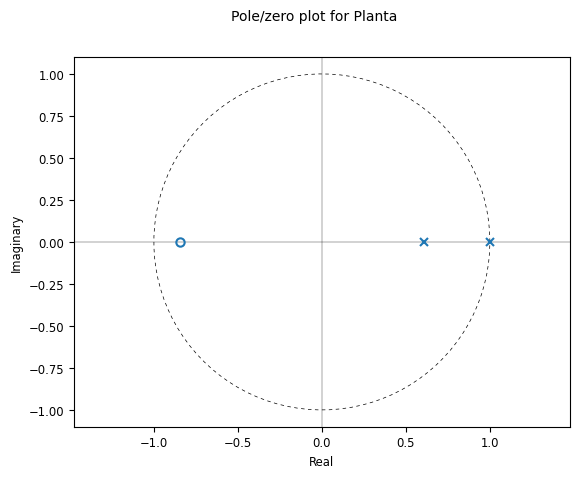

In [99]:
# Motor. Sistema continuo
s = ctrl.TransferFunction.s
K = 1.0
tau = 1.0
G = K / s / (tau * s + 1)

# Discretización
Gd = ctrl.c2d(G, Ts, method='zoh')
Gd.name = 'Planta'
print(f'Sistema discretizado: {Gd}')
ctrl.pzmap(Gd)

A = Gd.den[0][0]
B = Gd.num[0][0]
print(f'deg(A) = {len(A)-1}')
print(f'deg(B) = {len(B)-1}')

print(f'deg(R) = deg(T) = deg(S) = {len(A)-1-1}')
print(f'deg(Ac) = {len(A)-1+len(A)-1-1}')

# Paso 1: Factorizamos B
B_mas = B/(B[0])
B_menos = [B[0]]
Bm_bar = Bm/B_menos[0]

# Paso 2: Resolvemos la Diofantina
# deg(Ac)=3, deg(A)=2, deg(B+)=1 => deg(Ao)=0 => Ao=1
# deg(R)=1, deg(B+)=1 => deg(R_bar)=0 => R_bar=1 (x mónico)
# En este caso la ec. Diofantina resulta muy simple
Ao = [1]

# Posibilidad 1 para resolver la diofantina 
R_bar, S = diophantine_numeric(A,B_menos,np.polymul(Ao,Am))
# Quiero R_bar monico => obtengo Q para que suceda esto => tomo la sn. mínima de las infinitas que existen
Q = (1-R_bar[0])/B_menos[0]
# Obtengo R_bar y S para el Q dado
R_bar = np.polyadd(R_bar, np.polymul(Q,B_menos))
S = S - Q*A
idx = np.argmax(np.abs(S) > 1e-12)  # primera posición no nula
S = S[idx:]
print("**************\nResolución mínima posibilidad 1:")
print(f'R_bar={R_bar}')
print(f'S={S}')

# Posibilidad 2: calculo el cociente de polinomios sabiendo que R_bar es 1
R_bar=[1]
S, S_rem = np.polydiv(np.polyadd(np.polymul(Ao,Am),-A), B_menos)
idx = np.argmax(np.abs(S) > 1e-12)  # primera posición no nula
S = S[idx:]
print("\n**************\nResolución mínima posibilidad 2:")
print(f'R_bar={R_bar}')
print(f'S={S}')

# Verifico:
print(f'Verificación A*R_bar+B_menos*S - Am ={np.polyadd(np.polymul(A,R_bar),np.polymul(B_menos,S))-Am}')

# Paso 3: Construimos R y T
R = np.polymul(R_bar,B_mas)
T = np.polymul(Ao,Bm_bar)

print(f'R={R}')
print(f'S={S}')
print(f'T={T}')

/tmp/ipykernel_2349560/2899980708.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[k+1] = resp.y[:,-1]  # tomar valor al final del período


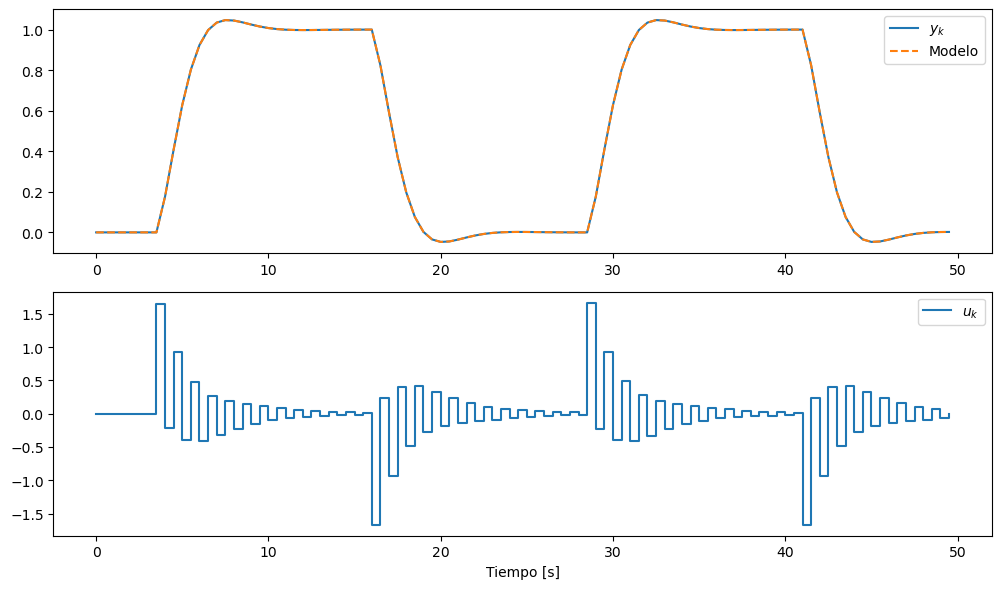

In [100]:
def simular_STR(G,Gm,S,T,R,t_final,Ts=0.5,sigma_v=0.1):
    # --- Simulación ---
    t = np.arange(0, t_final, Ts)
    n_steps = len(t)

    # Señales
    np.random.seed(0)
    r = 0.5 * (sc.signal.square(2*np.pi * t / 25 - np.pi/4) + 1)  # de 0 a 1
    v = sigma_v*np.random.randn(n_steps)
    #v = sigma_v*np.ones(n_steps)
    y = np.zeros(n_steps)
    u = np.zeros(n_steps)

    # Estado continuo
    Gss = ctrl.tf2ss(G)
    x = np.zeros(Gss.A.shape[0])
    for k in range(3, n_steps-1):
        # y[k] = salida actual
        # Calcular u[k] según controlador discreto:
        # R(q)u = T(q)r - S(q)y
        # => u[k] = (1/R0) * ( ... )

        # Calculo la acción de control del STR
        u[k] = (np.dot(T,r[k:k-len(T):-1]) 
                - np.dot(S, y[k:k-len(S):-1]) 
                - np.dot(R[1:], u[k-1:k-len(R):-1]))/R[0] 
        
        # Calculo la evolución de y usando el modelo de la planta discretizada
        #y[k+1] = (np.dot(B,u[k:k-len(B):-1]) - np.dot(A[1:], y[k:k+1-len(A):-1]))/A[0]

        # Simular dinámica continua con entrada u[k]
        resp = ctrl.forced_response(Gss, [t[k-1], t[k]], U=u[k]+v[k], X0=x,return_states=True)
        x = resp.states[:,-1]
        y[k+1] = resp.y[:,-1]  # tomar valor al final del período


    # Para comparar con el modelo
    t_m,y_m = ctrl.forced_response(Gm,t,U=r)

    plt.figure(figsize=(10,6))
    plt.subplot(2,1,1)
    plt.plot(t,y,label='$y_k$')
    plt.plot(t_m,y_m,'--',label='Modelo')
    plt.legend()
    plt.subplot(2,1,2)
    plt.step(t,u,where='post',label='$u_k$')
    plt.xlabel('Tiempo [s]')
    plt.tight_layout()
    plt.legend()

simular_STR(G,Gm,S,T,R,50,Ts,sigma_v=0)



# Ejemplo 3.2

Obtener un controlador STR sin cancelación del cero de la planta

R=[1.         0.11110524]
S=[ 1.64221634 -0.74707025]
T=[0.89514609 0.        ]
Verificación A*R_bar+B_menos*S - Am*Ao =[ 0.00000000e+00 -8.88178420e-16  2.22044605e-16  0.00000000e+00]

Modelo a seguir *******
Ganancia de continua = 1.0
Modelo a seguir <TransferFunction>: Modelo sin cancelación
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.5

   0.09536 z + 0.08075
  ---------------------
  z^2 - 1.32 z + 0.4966


/tmp/ipykernel_2349560/2899980708.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[k+1] = resp.y[:,-1]  # tomar valor al final del período


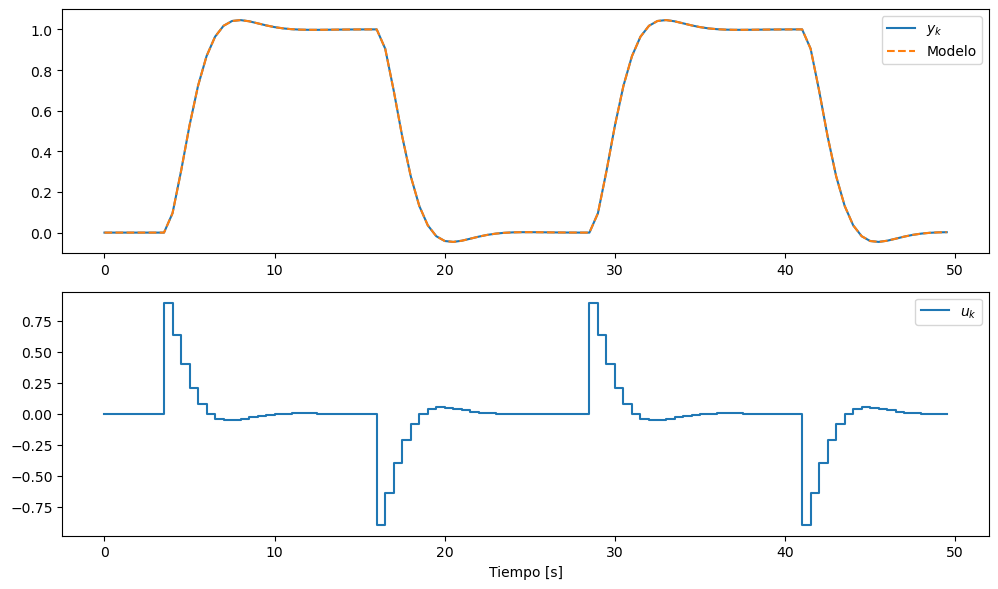

In [101]:
# Como A es de segundo orden y B es de primer orden y no buscamos cancelación, entonces 
# el controlador mínimo tiene a R,S y T de primer orden y el sistema de lc será de tercer orden
# Dos polos se especifican a través de Am, pero queda definir la ubicación del tercer polo

# Paso 1: Factorizamos B
B_mas = [1]
B_menos = B
# Como el cero de la planta no se cancela, entonces debe estar presente en el modelo
# Además la ganancia de continua debe ser unitaria
Bm_bar = np.sum(Am)/np.sum(B_menos)
Bm2 = B_menos * Bm_bar

# Paso 2: Resolvemos la Diofantina
# deg(Ac)=3, deg(A)=2, deg(B-)=1 => deg(Ao)=1 => Ao=[1 a0]
# deg(R)=1, deg(B+)=1 => deg(R_bar)=0 => R_bar=1 (x mónico)
# En este caso la ec. Diofantina resulta muy simple
Ao = [1, 0]

# Resuelvo la diofantina y busco la solución compatible con causalidad
R_bar, S = diophantine_numeric(A,B_menos,np.polymul(Ao,Am))
# Quiero R_bar monico de primer orden => obtengo Q para que suceda esto 
# => tomo la sn. mínima de las infinitas que existen
Q = (1-R_bar[0])/B_menos[0]

# Obtengo R_bar y S para el Q dado
R_bar = np.polyadd(R_bar, np.polymul(Q,B_menos))
S = np.polyadd(S, -np.polymul(Q,A))
idx = np.argmax(np.abs(S) > 1e-12)  # primera posición no nula
S = S[idx:]

# Paso 3: Construimos R y T
R = np.polymul(R_bar,B_mas)
T = np.polymul(Ao,Bm_bar)

print(f'R={R}')
print(f'S={S}')
print(f'T={T}')

# Verifico:
print(f'Verificación A*R_bar+B_menos*S - Am*Ao ={np.polyadd(np.polymul(A,R_bar),np.polymul(B_menos,S))-np.polymul(Am,Ao)}')

Gm2 = ctrl.TransferFunction(Bm2,Am,dt=Ts)
Gm2.name='Modelo sin cancelación'
print(f'\nModelo a seguir *******\nGanancia de continua = {np.sum(Bm2)/np.sum(Am)}')
print('Modelo a seguir',Gm2)

simular_STR(G,Gm2,S,T,R,50,Ts,sigma_v=0.0)



Modelo con cancelacion <TransferFunction>: Modelo
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.5

        0.1761 z
  ---------------------
  z^2 - 1.32 z + 0.4966


Modelo sin cancelacion <TransferFunction>: Modelo sin cancelación
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.5

   0.09536 z + 0.08075
  ---------------------
  z^2 - 1.32 z + 0.4966


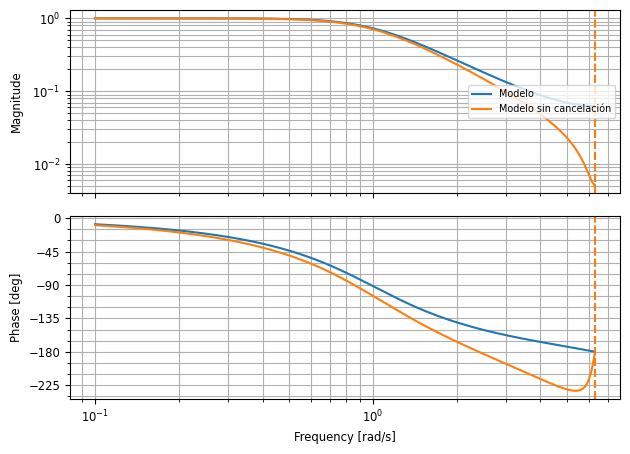

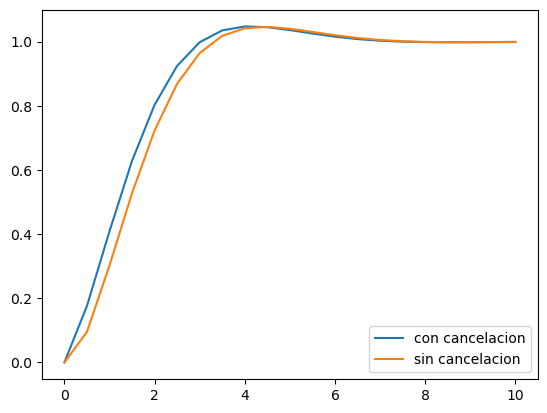

In [102]:
# Comparación de modelos
plt.figure()
ctrl.bode_plot(Gm)
ctrl.bode_plot(Gm2)

plt.figure()
t,y = ctrl.step_response(Gm)
plt.plot(t,y,label='con cancelacion')
t,y = ctrl.step_response(Gm2)
plt.plot(t,y,label='sin cancelacion')
plt.legend()

print('Modelo con cancelacion',Gm)
print('\n\nModelo sin cancelacion',Gm2)


# Ejemplo. Obtener un controlador con cancelación de cero y polo

- Se especifica un modelo de primer orden $deg(A_m)=1$ 
- Se cancela el polo estable y el cero
- El polo del integrador se ubica en z=0 

Luego de factorizar se tiene que: $ dim(A^-)=1 $ y $dim(B^-)=0$. Como se tiene cancelación de cero y polo, los órdenes de los controladores aumenta. De la ec. Diofantina
$$ A^- \bar{R} + B^- \bar{S} = \bar{A}_{lc}$$

se tiene 
- $dim(\bar{S})=dim(A^-)-1=0$
- $dim(A_{lc})=2-1 = 1$
- $dim(\bar{R})=0$

Con esto queda claro que $A_{lc}$ me define la nueva posición del polo en 0 que pone la planta.

Luego los polinomios se obtienen como:
- $R= A_m B^+ \bar{R}$    de dimensión $1+1+0=2$ mónico
- $S=A_m A^+ \bar{S}$    de dimensión $1+1+0=2$ 
- $T=\bar{B}_m \bar{A}_{lc} A^+$  de dimensión $0+1+1=2$ 

<TransferFunction>: Modelo de referencia
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.5

    0.3935
  ----------
  z - 0.6065

Resolución de la Diofantina (no mínima)
R_bar=[0.49717881]   S_bar=[4.71996689 4.66700211]
Primer coeficiente no nulo = 1
Luego de aplicar YK
R_bar=[1.]   S_bar=[9.386969]
Comprobación: A_menos*R_bar + B_menos*S_bar = [1.00000000e+00 2.22044605e-16]    Alc_bar=[1, 0]
Polinomios del controlador:
R=[ 1.          0.24021159 -0.51357514]
S=[  9.386969   -11.386969     3.45327291]
T=[ 3.6934845  -2.24021159  0.        ]


/tmp/ipykernel_2349560/2899980708.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[k+1] = resp.y[:,-1]  # tomar valor al final del período


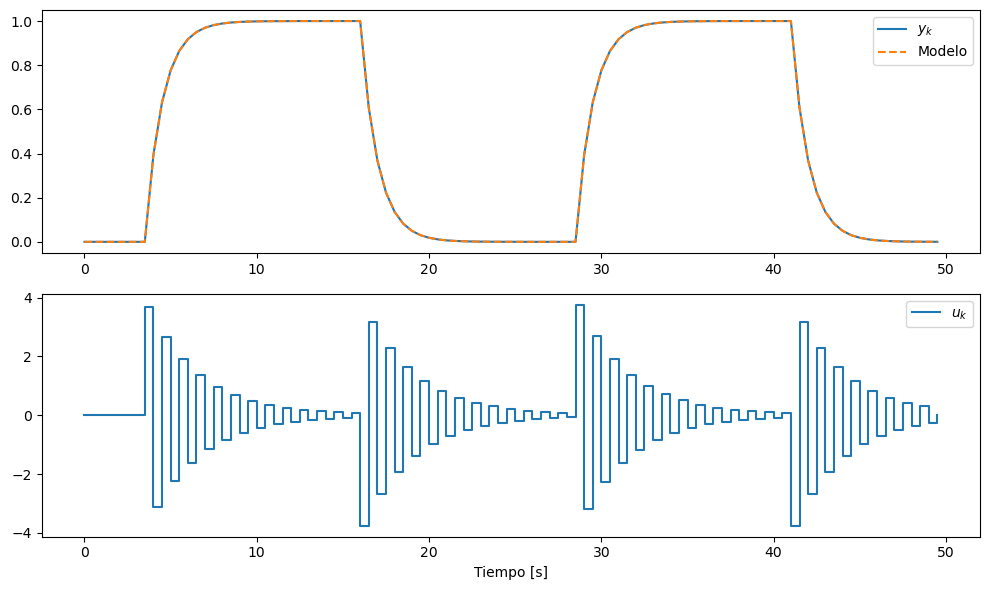

In [103]:
# Quiero seguimiento a un modelo de 1° orden. El resto de las dinámicas serán canceladas 
tau_m = 1.0 

# polos discretos (mapeo exacto s -> z)
z1 = np.exp(-Ts/tau_m)

# Armo el modelo a seguir
Am_c = np.poly([z1])              
Bm_c = [np.sum(Am_c)]
Gm_c = ctrl.TransferFunction(Bm_c,Am_c,dt=Ts)
Gm_c.name="Modelo de referencia"
print(Gm_c)

B_mas = B/B[0]
B_menos = [B[0]]
A_menos = np.poly([1])
A_mas = np.polydiv(A,A_menos)[0]
Bm_bar = np.polydiv(Bm_c,B_menos)[0]

# Paso 2: Resolvemos la Diofantina
# deg(Ac)=3, deg(A)=2, deg(B-)=1 => deg(Ao)=1 => Ao=[1 a0]
# deg(R)=1, deg(B+)=1 => deg(R_bar)=0 => R_bar=1 (x mónico)
# En este caso la ec. Diofantina resulta muy simple
Alc_bar = [1, 0]

# Resuelvo la diofantina y busco la solución compatible con causalidad
R_bar, S_bar = diophantine_numeric(A_menos,B_menos,Alc_bar)
print(f"\nResolución de la Diofantina (no mínima)\nR_bar={R_bar}   S_bar={S_bar}")

# Quiero R_bar monico de primer orden => obtengo Q para que suceda esto 
# => tomo la sn. mínima de las infinitas que existen
Q = (1-R_bar[0])/B_menos[0]

# Obtengo R_bar y S para el Q dado
R_bar = np.polyadd(R_bar, np.polymul(Q,B_menos))
S_bar = np.polyadd(S_bar, -np.polymul(Q,A_menos))
idx = np.argmax(np.abs(S_bar) > 1e-12)  # primera posición no nula
print(f"Primer coeficiente no nulo = {idx}")
S_bar = S_bar[idx:]
print(f"Luego de aplicar YK\nR_bar={R_bar}   S_bar={S_bar}")
print(f"Comprobación: A_menos*R_bar + B_menos*S_bar = {np.polyadd(np.polymul(A_menos,R_bar),np.polymul(B_menos,S_bar))}    Alc_bar={Alc_bar}")


# Paso 3: Construimos R y T
R = np.polymul(np.polymul(R_bar,B_mas),Am_c)
S = np.polymul(np.polymul(S_bar,A_mas),Am_c)
T = np.polymul(np.polymul(Alc_bar,A_mas),Bm_bar)


print(f'Polinomios del controlador:\nR={R}')
print(f'S={S}')
print(f'T={T}')

simular_STR(G,Gm_c,S,T,R,50,Ts,sigma_v=0.0)
